## Визуализация

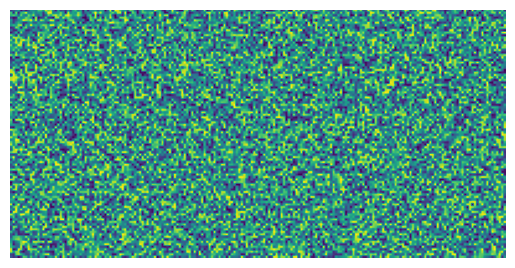

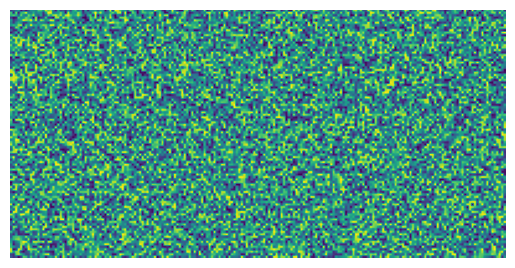

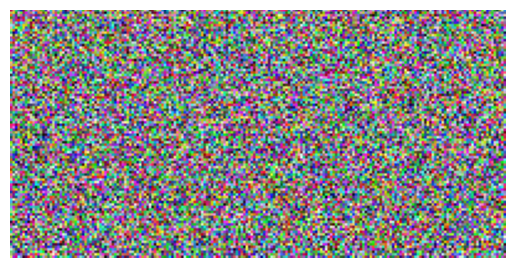

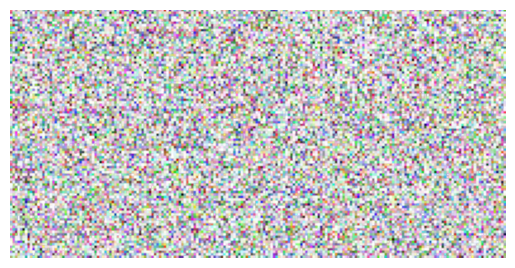

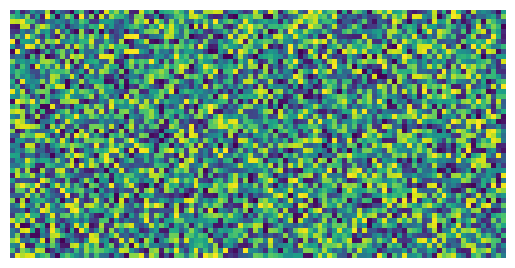

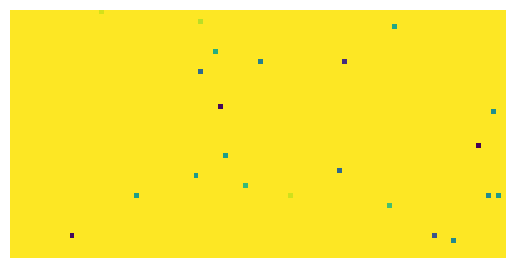

/var/folders/m9/y193wddj505gjbgjyvhjmzjm0000gq/T/ipykernel_37876/2236184966.py:25: RuntimeWarning: invalid value encountered in cast
  array = (array * 255).astype(np.uint8)  # Convert to uint8 for PIL


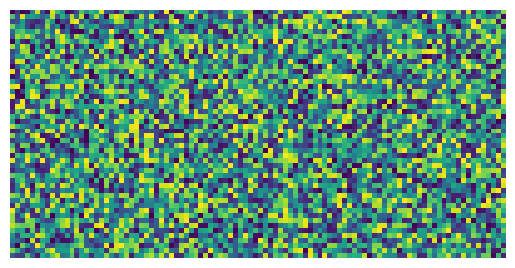

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 

MODE_LUMINANCE = 'L'
MODE_RGB = 'RGB'
MODE_RGBA = 'RGBA'
COLORMAP_VIRIDIS = 'viridis'

def visualize_array(array, colormap=None):
    """
    Visualizes a NumPy array as an image using Pillow.

    Args:
        array:  A NumPy array representing the image data.
                - It can be a 2D array (grayscale) or a 3D array (RGB or RGBA).
                - The data type should typically be uint8 (0-255) or float32/64 (0.0-1.0).
        color_map: (Optional) Colormap to use for grayscale images.
              If None (default) grayscale images are displayed directly.
              You can specify a matplotlib colormap name like 'viridis', 'magma', 'gray', etc.
    """

    if array.dtype == np.float32 or array.dtype == np.float64:
        array = np.clip(array, 0.0, 1.0)
        array = (array * 255).astype(np.uint8)  # Convert to uint8 for PIL
    elif array.dtype != np.uint8:
        print("Warning: Array data type is not uint8 or float.  Attempting to scale to uint8.")
        try:
            array = ((array - array.min()) / (array.max() - array.min()) * 255).astype(np.uint8)
        except ValueError:
            print("Error: Array contains NaN values or all values are the same. Cannot normalize.  Returning.")
            return

    if len(array.shape) == 2:
        mode = MODE_LUMINANCE
        if colormap:
            plt.imshow(array, cmap=colormap)
            plt.axis('off')
            plt.show()
            return
    elif len(array.shape) == 3:
        if array.shape[2] == 3:  # RGB
            mode = MODE_RGB
        elif array.shape[2] == 4:  # RGBA
            mode = MODE_RGBA
        else:
            raise ValueError("Array must have 2 (grayscale) or 3/4 (RGB/RGBA) channels.")
    else:
        raise ValueError("Array must be 2D or 3D.")

    image = Image.fromarray(array, mode=mode)

    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Example Usage
# 1. Grayscale Example
gray_array = np.random.randint(0, 256, size=(100, 200), dtype=np.uint8)
visualize_array(gray_array)
visualize_array(gray_array, colormap=COLORMAP_VIRIDIS)

# 2. RGB Example
rgb_array = np.random.randint(0, 256, size=(100, 200, 3), dtype=np.uint8)
visualize_array(rgb_array)

# 3. RGBA Example (with transparency)
rgba_array = np.random.randint(0, 256, size=(100, 200, 4), dtype=np.uint8)
visualize_array(rgba_array)

# 4. Float array example
float_array = np.random.rand(50, 100) # values from 0.0 to 1.0
visualize_array(float_array)

# 5. Float array with larger values
float_array2 = np.random.rand(50, 100) * 255.0  # Values from 0.0 to 255.0
visualize_array(float_array2) # Will need to be scaled.

# 6. Array with NaN values
nan_array = np.random.rand(50, 100)
nan_array[0,0] = np.nan #Introduce NaN
visualize_array(nan_array) #Handles the nan value and prints an error message.


## Классификация деревом принятия решений

In [2]:
from cgtnnlib.datasets import datasets

dataset = datasets[0]
dataset

Dataset #1 {
  name: "wisc_bc_data"
  learning_task: LearningTask(name='classification', criterion=CrossEntropyLoss(), y_dtype=torch.int64)
  classes_count: 2
  target: "diagnosis"
  _data: None
}

In [3]:
from sklearn import tree

model = tree.DecisionTreeClassifier()
model

DecisionTreeClassifier()

In [4]:
print('Target:', dataset.target)
train_df = dataset.data.train_df
test_df = dataset.data.test_df
test_target = test_df[dataset.target]
test_df = test_df.drop(dataset.target, axis=1)
X = train_df.drop(dataset.target, axis=1, inplace=False)
y = train_df[dataset.target]

(X, y)

Target: diagnosis
File data/wisc_bc_data.csv exists and SHA1 matches, skipping download.


(     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
 421       15.100         22.02           97.26      712.8          0.09056   
 275       28.110         18.47          188.50     2499.0          0.11420   
 154       14.410         19.73           96.03      651.0          0.08757   
 287       19.890         20.26          130.50     1214.0          0.10370   
 477       21.100         20.52          138.10     1384.0          0.09684   
 ..           ...           ...             ...        ...              ...   
 367        9.755         28.20           61.68      290.9          0.07984   
 554       13.210         25.25           84.10      537.9          0.08791   
 458        8.671         14.45           54.42      227.2          0.09138   
 537       11.700         19.11           74.33      418.7          0.08814   
 88        21.160         23.04          137.20     1404.0          0.09428   
 
      compactness_mean  concavity_mean  points_mea

In [5]:
model.fit(X, y)

DecisionTreeClassifier()

In [6]:
{
    "Depth": model.get_depth(),
    "Number of leaves": model.get_n_leaves(),
}

{'Depth': 8, 'Number of leaves': 23}

In [7]:
def percent(fraction: float) -> str:
    return f'{fraction * 100:.2f}%'

In [8]:
y_pred = model.predict(test_df)
score = model.score(test_df, test_target)
diff = y_pred - test_target
missclassified_count = diff[diff != 0].count()
correct_count = len(y_pred) - missclassified_count

print(f'Total: {correct_count}/{len(y_pred)} ({percent(score)})')
print(f'Predicted values:\n{y_pred}')
print(f'Actual values:\n{test_target.values}')
print(f'Diff: {diff.values}')

Total: 107/114 (93.86%)
Predicted values:
[1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1
 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 1
 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0
 1 0 0]
Actual values:
[1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1
 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 1
 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0
 1 0 1]
Diff: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  1  0  0  0  0  0 -1
  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0 -1]


In [9]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [10]:
dataset.data.df.columns.drop(dataset.target)

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean', 'points_mean',
       'symmetry_mean', 'dimension_mean', 'radius_se', 'texture_se',
       'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se',
       'concavity_se', 'points_se', 'symmetry_se', 'dimension_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'points_worst', 'symmetry_worst', 'dimension_worst'],
      dtype='object')

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname="Times New Roman"] ;
graph [ranksep=equally, splines=polyline] ;
edge [fontname="Times New Roman"] ;
0 [label=<node &#35;0<br/>points_worst &le; 0.14545<br/>gini = 0.474377<br/>samples = 100.0%<br/>value = [0.386813, 0.613187]<br/>class = bar>, fillcolor="#b6dbf5"] ;
1 [label=<node &#35;1<br/>area_worst &le; 957.450012<br/>gini = 0.173098<br/>samples = 66.6%<br/>value = [0.09571, 0.90429]<br/>class = bar>, fillcolor="#4ea7e8"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<node &#35;2<br/>points_worst &le; 0.13185<br/>gini = 0.074717<br/>samples = 62.2%<br/>value = [0.038869, 0.961131]<br/>class = bar>, fillcolor="#41a1e6"] ;
1 -> 2 ;
3 [label=<node &#35;3<br/>area_se &le; 91.555<br/>gini = 0.03744<br/>samples = 57.6%<br/>value = [0.019084, 0.980916]<br/>class = bar>, fillcolor="#3d9fe6"] ;
2 -> 3 ;
4 [label=<node &#35;4<br/>area_worst &le; 893.649994<br/>gini = 0.030182<br/>samp

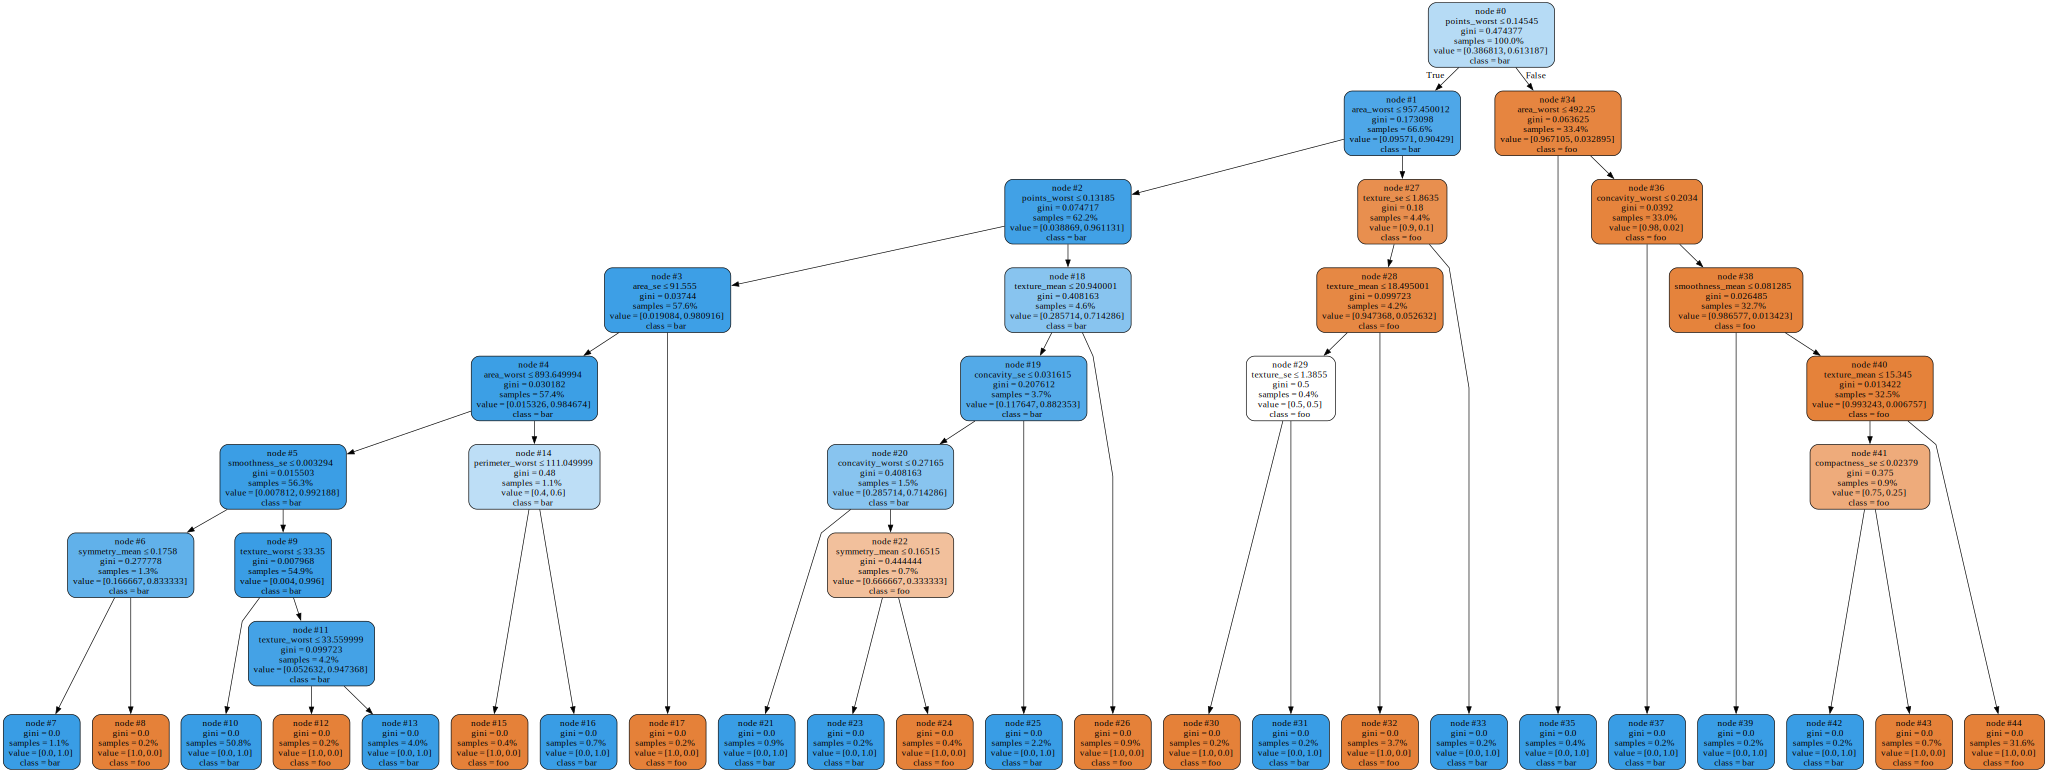

In [11]:

import graphviz

graphviz_source = tree.export_graphviz(
    decision_tree=model,
    feature_names=dataset.data.df.columns.drop(dataset.target),
    class_names=['foo', 'bar', 'baz', 'qux'],
    filled=True,
    leaves_parallel=True,
    node_ids=True,
    proportion=True,
    # rotate=True,
    rounded=True,
    special_characters=True,
    precision=6, # digits after point
    fontname='Times New Roman',
    # fontname='Big Caslon',
    # fontname='Brush Script MT',
)
print(graphviz_source)
graphviz.Source(graphviz_source)

## AugmentedReLUNetwork

- [ ] Попробовать инициализацию Хе

N=0 #1 gNoNoise p=0.5 E59/60 S38 Loss=0.0026@AugmentedReLUNetwork


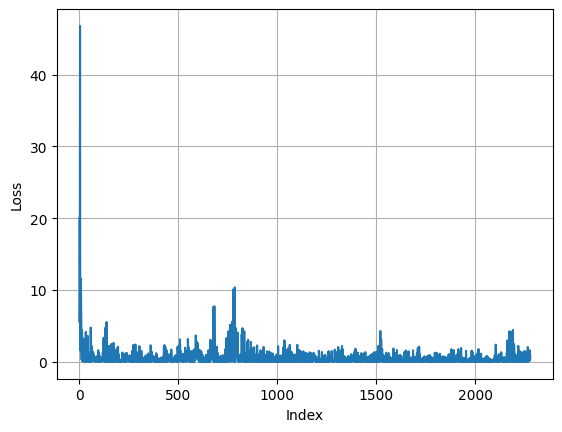

In [12]:
import torch.optim as optim
from cgtnnlib.plt_extras import plot_list
from cgtnnlib.training import init_weights_xavier, train_model
from cgtnnlib.nn.AugmentedReLUNetwork import AugmentedReLUNetwork
from cgtnnlib.constants import EPOCHS, LEARNING_RATE


from cgtnnlib.datasets import datasets

dataset = datasets[0]
dataset

P = 0.5

model = AugmentedReLUNetwork(
    inputs_count=dataset.features_count,
    outputs_count=dataset.classes_count,
    p=P,
)

model.apply(init_weights_xavier)

losses = train_model(
    model=model,
    dataset=dataset,
    epochs=EPOCHS * 3,
    iteration=0,
    p=P,
    criterion=dataset.learning_task.criterion,
    optimizer=optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
    ),
)

plot_list(losses, y_label='Loss')

In [13]:
import torch

def score(model, dataloader, loss_fn, metric="accuracy", device="cpu"):
    """
    Calculates a score for a PyTorch model on a given dataset.

    Args:
        model (nn.Module): The PyTorch model to evaluate.
        dataloader (DataLoader): The DataLoader containing the data.
        loss_fn (callable): The loss function to use (e.g., nn.CrossEntropyLoss()).
        metric (str, optional): The metric to use for scoring.  Defaults to "accuracy".
                                  Can be "accuracy", "loss", or a custom function.
        device (str, optional): The device to run the evaluation on (e.g., "cpu" or "cuda").
                                Defaults to "cpu".

    Returns:
        float: The calculated score.  Returns the mean loss if metric is "loss".
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * inputs.size(0) # weighted by batch size

            if metric == "accuracy":
                _, predicted = torch.max(outputs.data, 1)  # Get predicted class
                correct += (predicted == labels).sum().item()
            elif callable(metric):
                # Use the provided custom metric function
                correct += metric(outputs, labels).item()

            total_samples += inputs.size(0)  # Accumulate total samples

    avg_loss = total_loss / total_samples

    if metric == "accuracy":
        accuracy = correct / total_samples
        return accuracy
    elif metric == "loss":
        return avg_loss
    elif callable(metric):
         accuracy = correct / total_samples
         return accuracy
    else:
        raise ValueError(f"Unsupported metric: {metric}.  Choose 'accuracy', 'loss', or a callable.")

score(model, dataset.data.test_loader, dataset.learning_task.criterion, metric="accuracy")

0.9298245614035088

Таким образом, $\text{accuracy} = 92,98\%$. У `DecisionTreeClassifier` $\text{accuracy}_T = 93,86\%$

## Сравнение с обычным дропаутом

In [14]:
import numpy as np

mine = 47.0
their = 46.5
data = [mine, 46.0, 47.2, 46.6, 47.3, 45.8, their]
mean = np.mean(data)
std = np.std(data)
print('mean = ', mean)
print('|mean - mine| =', np.abs(np.mean(data) - mine))
print('std = ', std)
print('3 * std = ', 3 * std)
print('3 * std / (mean - mine) = ', 3 * std / (mean - mine))


mean =  46.628571428571426
|mean - mine| = 0.37142857142857366
std =  0.5364280958719602
3 * std =  1.6092842876158806
3 * std / (mean - mine) =  -4.332688466658114


In [15]:
np.ptp(data)

1.5

In [16]:
np.mean([1, 2, 3, 4])

2.5

In [17]:
np.mean([1, 2])

1.5

In [18]:
np.mean([3, 4])

3.5

In [19]:
np.mean([2.5, 1.5])

2.0